In [1]:
import re
import pandas as pd
import numpy as np
import time
import random
import requests
import math
import sys
import string
import pickle
from itertools import chain
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
from itertools import combinations
from collections import OrderedDict 
import nltk

# Scraping

In [11]:
import urllib.request, urllib.parse
from bs4 import BeautifulSoup
import csv
import random
from fake_useragent import UserAgent
from datetime import timedelta, date

## Get Dates

Getting valid dates, code inspired from [here](https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-50.php)


In [12]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [13]:
dates = []
start_dt = date(2020, 1, 1)
end_dt = date(2020, 6, 23)
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%Y%m%d"))

In [19]:
date_range = []
for i in range(len(dates)-1):
    date_range.append((int(dates[i]), int(dates[i+1])))

In [20]:
date_range[0:5]

[(20200101, 20200102),
 (20200102, 20200103),
 (20200103, 20200104),
 (20200104, 20200105),
 (20200105, 20200106)]

## Scrape news links from the [Naver News portal](https://news.naver.com/)

### Helper Methods

In [14]:
def add_dots_to_dates(date):
 return re.sub(r'(\d\d\d\d)(\d\d)(\d\d)', r'\1.\2.\3', date)

In [28]:
# def get_params(query, page, start_date, end_date):
#   return urllib.parse.urlencode({
#     'where': 'news',
#     'query': query, 
#     'sm':'tab_opt',
#     'pd':'3',
#     'ds': add_dots_to_dates(start_date),
#     'de': add_dots_to_dates(end_date),
#     'nso':f'so:dd,p:from{start_date}to{end_date},a:all', 
#     'mynews':'1',
#     'start':(page-1)*10+1,
#     'refresh_start':'0'
#  })

def get_params(query, page, start_date, end_date):
  return urllib.parse.urlencode({
          'where': 'news',
          'query': query, #검색어(기사 본문)
          'sm':'tab_opt',
          'sort':'0',
          'photo':'0',
          'field':'0',
          'reporter_article':'',
          'pd':'3',
          'ds': add_dots_to_dates(start_date),
          'de': add_dots_to_dates(end_date),
          'docid':'',
          'nso':f'so:dd,p:from{start_date}to{end_date},a:all', #검색 시작일, 종료일
          'mynews':'1',
          'start':(page-1)*10+1,
          'refresh_start':'0',
      })


In [16]:
def get_cookies():
  return {
    "news_office_checked": "1032,1020,1023,1025,1028",
    "news_my_status": "1"
  }

In [17]:
def get_headers():
  ua = UserAgent()
  fua = ua.random
  headers = {'User-Agent': fua}
  return headers

In [22]:
query = "코로나"

In [ ]:
for date in date_range:
    start_date, end_date = date
    article_title = []
    article_outlet = []
    article_date = []
    article_url = []
    print(f"For dates in range {start_date}-{end_date}")

    # This will get reset with each round
    num_articles_to_scrape = 2000

    page = 0
    while True:
        time.sleep(random.random()*3)

        params = get_params(query, page, str(start_date), str(end_date))
        request_url = 'https://search.naver.com/search.naver?&%s' % params
        cookies = get_cookies()
        headers = get_headers()
        req = requests.get(request_url, headers=headers, cookies=cookies)
        soup = BeautifulSoup(req.text, 'lxml')

        # Find all of the links
        mylist = soup.find_all('li', attrs={'id':re.compile(r'sp_nws')})
        num_results = len(mylist)
        print("Results on this page", num_results)

        total_articles = int(re.search(r'\/\s(.*)건', soup.find("div", class_="title_desc").text).group(1).replace(',', ''))
        print("Total articles", total_articles)
        total_pages = math.ceil(total_articles/10)

        if page == total_pages+1:
            break

        print(f"Page {page}/{total_pages}")
      
        for li in mylist:
            title='NA'
            outlet = 'NA'
            date = 'NA'
            contacttracing = 'NA'
            lead = 'NA'
            url = 'NA'

            title = li.find('a', attrs={'class':re.compile(r'_sp_each_title')}).get('title').strip()
            outlet = li.find('span', attrs={'class':'_sp_each_source'}).text.strip()
            date = li.find('span', attrs={'class':'bar'}).next_sibling.strip()
            url = li.find('a')['href']

            # if outlet in news:
            article_title.append(title)
            article_outlet.append(outlet)
            article_date.append(date)
            article_url.append(url)
    
    page += 1

    # Convert into dataframe
    if len(article_title) > 0:
        print("Creating dataframe")
        df = pd.DataFrame.transpose(pd.DataFrame([article_outlet, article_date, article_title, article_url]))
        df.columns = ['outlet', 'date', 'title','url']
        df['keyword'] = query

        df.reset_index(drop=True, inplace=True)
        df.drop_duplicates(inplace=True)
        df.to_csv(f"data/rawdata/naver_news{start_date}-{end_date}.csv")

## Concat all the data

In [ ]:
from os import walk

f = []
mypath = "data/rawdata/"
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)

In [ ]:
df = pd.concat([pd.read_csv(mypath + a) for a in f])

In [ ]:
print(len(df))
df.drop_duplicates(subset=['url'], inplace=True)
df.drop(columns = "Unnamed: 0", inplace=True)
df.reset_index(drop=True, inplace=True)
print(len(df))

In [ ]:
df.to_csv("naver_news.csv")

## Scrape Content of Individual Articles


In [33]:
def digital_chosun(url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml') 
    for script in soup(["script", "style"]):
        script.decompose()     
    a = soup.find('div', attrs={'class':'inputdate'}).text
    date = re.search(r'(\d\d\d\d.\d\d.\d\d)', a).group()
    text = soup.findAll('div', attrs={'class':'article'})[0].text.strip()
    return (date,text)

In [34]:
def donga(url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml') 
    for script in soup(["script", "style"]):
        script.decompose() 
    a = soup.find('span', attrs={'class':re.compile(r'date01')}).text
    date = re.search(r'(\d\d\d\d.\d\d.\d\d)', a).group()
    text = soup.findAll('div', attrs={'class':'article_txt'})[0].text.strip()
    return (date,text)

In [35]:
def khan(url):
    agent = {"User-Agent":"Mozilla/5.0"}
    req = urllib.request.Request(url, headers=agent)    
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml')
    
    a = soup.find("div", attrs={"class": "byline"})
    date = re.search(r'(\d\d\d\d.\d\d.\d\d)', a.find("em").text).group()

    soup.find("h1").text
    text = ' '.join([a.text for a in soup.findAll("p", attrs={"class": "content_text"})])
    return (date,text)  

In [36]:
def jungang_ilbo(url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml') 
    for script in soup(["script", "style"]):
        script.decompose()     
    a = soup.select(".byline > em:nth-of-type(2)")[0].text
    date = re.search(r'(\d\d\d\d.\d\d.\d\d)', a).group()
    text = soup.findAll('div', attrs={'class':'article_body'})[0].text.strip()
    return (date, text)

In [ ]:
def hangurae(url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml') 
    for script in soup(["script", "style"]):
        script.decompose()     
    a = soup.find('p', attrs={'class':re.compile(r'date-time')})
    date = re.search(r'(\d\d\d\d.\d\d.\d\d)', a.span.text).group()
    text = soup.findAll('div', attrs={'class':'text'})[0].text.strip()
    return (date, text)

In [ ]:
def chosun_ilbo(url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml') 
    for script in soup(["script", "style"]):
        script.decompose()     
    a = soup.find('div', attrs={'class':re.compile(r'news_date')}).string
    date = re.search(r'(\d\d\d\d.\d\d.\d\d)', a).group()
    text = soup.findAll('div', attrs={'class':'par'})[0].text.strip()
    return (date, text)

In [ ]:
def get_text(url, outlet):
    try:
        if "seouland" in url:
            return "NA"
        if "디지틀조선일보" in outlet:
            return digital_chosun(url)
        if "조선일보" in outlet:
            return chosun_ilbo(url)
        if "한겨레" in outlet:
            return hangurae(url)
        if "중앙일보" in outlet:
            return jungang_ilbo(url)
        if "동아일보" in outlet:
            return donga(url)
        if "경향신문" in outlet:
            return khan(url)
        else: 
          print("Not Valid")
          return "NA"
    except:
        e = sys.exc_info()[0]
        print("Exception", e)

In [ ]:
df = pd.read_csv("data/naver_news.csv")
len(df)

In [ ]:
# Separate the date, text tuple; convert the date to proper datetime format

for index in df.index:
    print(index, df.loc[index, 'date'])
    try:
        date, text = get_text(df.loc[index, 'url'], df.loc[index, 'outlet'])
        if (date != "N") :
            df.loc[index, 'date'] = pd.to_datetime(date) 
        df.loc[index, 'text'] = text

    except:
        print("Exception, skipping")

In [ ]:
df.to_csv("naver_news.csv")

# Cleaning

## Helper Methods

In [82]:
def find_top_frequent_words(documents, top_n):
    dist = nltk.FreqDist(documents)
    top_frequent = []
    for keys in dist.most_common(top_n):
#         print(keys)
        a,b = keys
        top_frequent.append(keys)
    return top_frequent

In [83]:
def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, list):
            list_flatten(i, a)
        else:
            if (len(i) != 1): a.append(i)
    return a

## Basic Cleaning

In [55]:
def clean_text(text):
    remove_char = string.punctuation + '…' + '\xa0' + '·' + '\n' + \
        '※' + '‘' + '’' + '\'' + '▲' + '∼' + "△" + "“" + "”" + "▶" + "․" + \
        "▸"
    text = re.sub('http[s]?://\S+', '', text) # Remove http urls
    text = re.sub('\S*@\S*\s?', '', text) # Remove emails
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(remove_char), '', text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub('\'', '', text)
    text = re.sub(r'Copyright .* rights reserved', '', text) # Remove "Copyright all rights reserved"
    return text

In [50]:
df = pd.read_csv("data/naver_news.csv")

In [51]:
df.drop(inplace=True, columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1'])

In [52]:
df.columns

Index(['outlet', 'date', 'title', 'url', 'keyword', 'text'], dtype='object')

In [53]:
df.head()

,outlet,date,title,url,keyword,text
0,한겨레언론사 선정,2020-02-03 00:00:00,‘코로나맵’ 이어…대학생들이 만든 ‘코로나 알리미’ 등장,http://www.hani.co.kr/arti/society/society_gen...,코로나,3일 ‘코로나 알리미’에 표시된 확진자 방문 장소와 진료 가능 의료기관. 코로나 알...
1,경향신문언론사 선정,2020-02-03 00:00:00,"[속보]육군 병사, 신종 코로나 확진자와 접촉 확인···증상은 없어",http://news.khan.co.kr/kh_news/khan_art_view.h...,코로나,육군의 한 병사가 신종 코로나바이러스 감염증의 확진자와 접촉했던 것으로 나타났다. ...
2,동아일보언론사 선정,2020-02-03 00:00:00,베트남행 여객기서 50대 한국인 사망…“신종 코로나와 무관”,http://www.donga.com/news/article/all/20200203...,코로나,사진=VN익스프레스 인터내셔널 홈페이지 캡처인천국제공항에서 베트남 하노이로 향하던 ...
3,중앙일보언론사 선정,2020-02-03 00:00:00,"日전문가 ""신종 코로나, 전염성 강하지만 가벼운 증상 많아""",https://news.joins.com/article/olink/23290856,코로나,일본 도쿄 시민들이 신종 코로나 예방을 위해 마스크를 쓰고 거리를 걷고 있다. [A...
4,중앙일보언론사 선정,2020-02-03 00:00:00,코로나발 對中수출 직격타…피해 기업에 4000억 긴급지원,https://news.joins.com/article/olink/23291124,코로나,중국 우한에서 발생한 신종 코로나바이러스 감염증 여파로 국내 기업의 수출 피해가 가...


In [54]:
print("Df len before dropping null", len(df))

print("Number of null texts", len(df[df['text'].isnull()]))

# Just drop the null ones. There are only 4
df = df[~df['text'].isnull()]

print("New df len", len(df))

Df len before dropping null 51531
Number of null texts 220
New df len 51311


In [56]:
df['text_clean'] = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [ ]:
df.to_csv("data/korean_news_raw.csv")

In [57]:
df.to_pkl("data/korean_news_raw.pkl")

## Lemmatize, Tokenize

Lemmatizing using Part-Of-Speech Tagging, inspired by this [blog post](https://lovit.github.io/nlp/2019/01/22/trained_kor_lemmatizer/).

Using [soylemma](https://pypi.org/project/soylemma/) for Korean lemmatization. [Github](https://github.com/lovit/korean_lemmatizer) page here


In [ ]:
from soylemma import Lemmatizer
lemmatizer = Lemmatizer()

In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
# Import Korean stop words from https://github.com/stopwords-iso/stopwords-ko
import json
with open('data/korean_stopwords.json') as f:
  stopwords = json.load(f)

# Add some extra words
stopwords.extend(['에서', '으로', '이다', '는', '한', '은', '씨', 'A', '서', 
                  '다', '했다', '하는', 'ㆍ', '었다', '있는', '한다', '하고',
                  '있다고', '에는', '한다', '된다', '이라고', '하면', '했다고',
                  '에는', '', '보다', '하기', '라고', '이라는', '라는', '했던',
                  '하셨습니다', '하겠다고', '하다', '되다', '히다'])

In [59]:
df = pd.read_pickle("data/korean_news_raw.pkl")

In [66]:
def get_news_source(outlet):
    if "경향신문" in outlet:
        return "경항신문"
    if "동아일보" in outlet:
        return "동아일보"
    if "조선일보" in outlet:
        return "조선일보"
    if "중앙일보" in outlet:
        return "중앙일보"
    if "한겨레" in outlet:
        return "한겨레"

In [ ]:
for index in df.index:
    print(index)
    morphemes = []
    result = okt.pos(df.loc[index, 'text_clean'])
    
    for word,pos in result:
        if pos == "Noun" or pos == "Adjective":
            morphemes.append(word)
        if pos == "Verb" or pos == "Adverb":
            result = lemmatizer.lemmatize(word)
            if not result:
                morphemes.append(word)
            else: 
                lem_word, lem_pos = result[0] # Just get the first result
                morphemes.append(lem_word)

    morphemes = [a for a in morphemes if a not in stopwords]
    joined = ' '.join(morphemes)
    morphemes = joined.replace('확 진자', '확진자')
    morphemes = morphemes.replace('문 재인', '문재인')
    morphemes = morphemes.replace('알 리미', '알리미')

    df.loc[index, "text_proc"] = morphemes

After this, see frequent words, and use that to add the most frequent things to stop words

In [86]:
[c.split(' ') for c in df['text_proc']]

AttributeError: 'NoneType' object has no attribute 'split'

In [90]:
df.dropna(subset=['text_proc'])

,Unnamed: 0,outlet,date,title,url,keyword,text,text_clean,text_proc
0,0,한겨레언론사 선정,2020-02-03 00:00:00,‘코로나맵’ 이어…대학생들이 만든 ‘코로나 알리미’ 등장,http://www.hani.co.kr/arti/society/society_gen...,코로나,3일 ‘코로나 알리미’에 표시된 확진자 방문 장소와 진료 가능 의료기관. 코로나 알...,코로나 알리미에 표시된 확진자 방문 장소와 진료 가능 의료기관 코로나 알리미 갈무...,코로나 알리 미에 표시 확진자 방문 장소 진료 가능 의료 기관 코로나 알리미 갈무리...
1,1,경향신문언론사 선정,2020-02-03 00:00:00,"[속보]육군 병사, 신종 코로나 확진자와 접촉 확인···증상은 없어",http://news.khan.co.kr/kh_news/khan_art_view.h...,코로나,육군의 한 병사가 신종 코로나바이러스 감염증의 확진자와 접촉했던 것으로 나타났다. ...,육군의 한 병사가 신종 코로나바이러스 감염증의 확진자와 접촉했던 것으로 나타났다 해...,육군 병사 신종 코로나바이러스 감염증 확진자 접촉 나타나다 해당 병사 비롯 생활관 ...
2,2,동아일보언론사 선정,2020-02-03 00:00:00,베트남행 여객기서 50대 한국인 사망…“신종 코로나와 무관”,http://www.donga.com/news/article/all/20200203...,코로나,사진=VN익스프레스 인터내셔널 홈페이지 캡처인천국제공항에서 베트남 하노이로 향하던 ...,사진VN익스프레스 인터내셔널 홈페이지 캡처인천국제공항에서 베트남 하노이로 향하던 베...,사진 익스 프레 스 인터내셔널 홈페이지 캡처 국제공항 베트남 하노이 향 베트남항공 ...
3,3,중앙일보언론사 선정,2020-02-03 00:00:00,"日전문가 ""신종 코로나, 전염성 강하지만 가벼운 증상 많아""",https://news.joins.com/article/olink/23290856,코로나,일본 도쿄 시민들이 신종 코로나 예방을 위해 마스크를 쓰고 거리를 걷고 있다. [A...,일본 도쿄 시민들이 신종 코로나 예방을 위해 마스크를 쓰고 거리를 걷고 있다 ...,일본 도쿄 시민 신종 코로나 예방 위해 마스크 쓰다 거리 걷다 신종 코로나바이러스 ...
4,4,중앙일보언론사 선정,2020-02-03 00:00:00,코로나발 對中수출 직격타…피해 기업에 4000억 긴급지원,https://news.joins.com/article/olink/23291124,코로나,중국 우한에서 발생한 신종 코로나바이러스 감염증 여파로 국내 기업의 수출 피해가 가...,중국 우한에서 발생한 신종 코로나바이러스 감염증 여파로 국내 기업의 수출 피해가 가...,중국 우한 발생 신종 코로나바이러스 감염증 여파 국내 기업 수출 피해 가시 화하자 ...
...,...,...,...,...,...,...,...,...,...
57834,51465,동아일보,2020-06-22 00:00:00,의정부 랜드마크 지식산업센터 탄생 예고 … ‘의정부 센텀스퀘어’ 공급,https://www.donga.com/news/article/all/2020061...,코로나,‘의정부 센텀스퀘어’ 투시도 의정부 신규 택지지구인 고산지구에 의정부 최초이자 북부...,의정부 센텀스퀘어 투시도 의정부 신규 택지지구인 고산지구에 의정부 최초이자 북부권 ...,의정부 센텀 스퀘어 투시도 의정부 신규 택지 지구인 고산 지구 의정부 최초 이자 북...
57835,51466,중앙일보,2020-06-23 00:00:00,"[글로벌 아이] 돈 쓸 궁리, 돈 벌 궁리",https://news.joins.com/article/olink/23402438,코로나,서승욱 도쿄총국장 신종 코로나바이러스 감염증(코로나 19)이 한고비를...,서승욱 도쿄총국장 신종 코로나바이러스 감염증코로나 한고비를 넘었다는...,서승욱 도쿄 국장 신종 코로나바이러스 감염증 코로나 한고비 넘다 일본엔 지난 중요한...
57836,51467,중앙일보,2020-06-22 00:00:00,[오종남의 퍼스펙티브] ‘기업 하기 좋은 나라’ 만들어 선진국 도약하자,https://news.joins.com/article/olink/23401495,코로나,K방역 이후 한국의 과제 외환위기 때인 1997년 12월 새마을부녀회연...,K방역 이후 한국의 과제 외환위기 때인 새마을부녀회연합회가 금 모으...,방역 이후 한국 과제 외환위기 새마을 부녀회 연합 회 금 모으 기 시초 애국 가락지...
57837,51468,중앙일보,2020-06-22 00:00:00,"문 대통령 “추경 6월 통과, 비상한 방법 강구” 여당 단독처리?",https://news.joins.com/article/olink/23401429,코로나,문재인 문재인(얼굴) 대통령이 “제3차 추경안의 6월 통과가 무산돼선...,문재인 문재인얼굴 대통령이 추경안의 통과가 무산돼선 안 된다 비상...,문재인 문재인 얼굴 대통령 추경안 통과 무산 선 안 비상한 방법 강 구해 말 문 대...


In [ ]:
ko_tokens = list_flatten([c.split(' ') for c in df['text_proc']])

In [ ]:
find_top_frequent_words(ko_tokens,300)

[('받다', 55261),
 ('확진자', 53242),
 ('코로나', 52877),
 ('않다', 52597),
 ('중국', 48222),
 ('감염', 46753),
 ('정부', 46330),
 ('지난', 41755),
 ('신종', 40866),
 ('환자', 40248),
 ('밝히다', 39693),
 ('대통령', 39518),
 ('기자', 38592),
 ('미국', 37826),
 ('한국', 34743),
 ('지역', 34596),
 ('나오다', 33312),
 ('따르다', 32799),
 ('위해', 32727),
 ('검사', 32109),
 ('확산', 31656),
 ('대한', 31469),
 ('방역', 30480),
 ('상황', 30091),
 ('마스크', 30061),
 ('관련', 28784),
 ('코로나바이러스', 28529),
 ('확진', 27270),
 ('격리', 26859),
 ('병원', 26742),
 ('지원', 26540),
 ('서울', 25747),
 ('사람', 25466),
 ('발생', 24216),
 ('판정', 23799),
 ('사회', 23695),
 ('의료', 23575),
 ('바이러스', 23528),
 ('국민', 23196),
 ('사태', 23118),
 ('이후', 22839),
 ('때문', 21855),
 ('세계', 21440),
 ('경제', 20903),
 ('대해', 20691),
 ('오다', 20657),
 ('통해', 20275),
 ('늘다', 20136),
 ('경우', 19476),
 ('같은', 19147),
 ('지난달', 19032),
 ('크다', 18943),
 ('결과', 18940),
 ('우한', 18834),
 ('대구', 18780),
 ('대책', 18674),
 ('기업', 18543),
 ('확인', 18411),
 ('국내', 18330),
 ('추진', 17964),
 ('추미애', 17753),
 ('현재', 

In [75]:
df.to_csv("data/korean_proc.csv")

In [79]:
df = pd.read_csv("data/korean_proc.csv", engine="python")

In [80]:
df.head()

,Unnamed: 0,outlet,date,title,url,keyword,text,text_clean,text_proc
0,0,한겨레언론사 선정,2020-02-03 00:00:00,‘코로나맵’ 이어…대학생들이 만든 ‘코로나 알리미’ 등장,http://www.hani.co.kr/arti/society/society_gen...,코로나,3일 ‘코로나 알리미’에 표시된 확진자 방문 장소와 진료 가능 의료기관. 코로나 알...,코로나 알리미에 표시된 확진자 방문 장소와 진료 가능 의료기관 코로나 알리미 갈무...,코로나 알리 미에 표시 확진자 방문 장소 진료 가능 의료 기관 코로나 알리미 갈무리...
1,1,경향신문언론사 선정,2020-02-03 00:00:00,"[속보]육군 병사, 신종 코로나 확진자와 접촉 확인···증상은 없어",http://news.khan.co.kr/kh_news/khan_art_view.h...,코로나,육군의 한 병사가 신종 코로나바이러스 감염증의 확진자와 접촉했던 것으로 나타났다. ...,육군의 한 병사가 신종 코로나바이러스 감염증의 확진자와 접촉했던 것으로 나타났다 해...,육군 병사 신종 코로나바이러스 감염증 확진자 접촉 나타나다 해당 병사 비롯 생활관 ...
2,2,동아일보언론사 선정,2020-02-03 00:00:00,베트남행 여객기서 50대 한국인 사망…“신종 코로나와 무관”,http://www.donga.com/news/article/all/20200203...,코로나,사진=VN익스프레스 인터내셔널 홈페이지 캡처인천국제공항에서 베트남 하노이로 향하던 ...,사진VN익스프레스 인터내셔널 홈페이지 캡처인천국제공항에서 베트남 하노이로 향하던 베...,사진 익스 프레 스 인터내셔널 홈페이지 캡처 국제공항 베트남 하노이 향 베트남항공 ...
3,3,중앙일보언론사 선정,2020-02-03 00:00:00,"日전문가 ""신종 코로나, 전염성 강하지만 가벼운 증상 많아""",https://news.joins.com/article/olink/23290856,코로나,일본 도쿄 시민들이 신종 코로나 예방을 위해 마스크를 쓰고 거리를 걷고 있다. [A...,일본 도쿄 시민들이 신종 코로나 예방을 위해 마스크를 쓰고 거리를 걷고 있다 ...,일본 도쿄 시민 신종 코로나 예방 위해 마스크 쓰다 거리 걷다 신종 코로나바이러스 ...
4,4,중앙일보언론사 선정,2020-02-03 00:00:00,코로나발 對中수출 직격타…피해 기업에 4000억 긴급지원,https://news.joins.com/article/olink/23291124,코로나,중국 우한에서 발생한 신종 코로나바이러스 감염증 여파로 국내 기업의 수출 피해가 가...,중국 우한에서 발생한 신종 코로나바이러스 감염증 여파로 국내 기업의 수출 피해가 가...,중국 우한 발생 신종 코로나바이러스 감염증 여파 국내 기업 수출 피해 가시 화하자 ...


# Topic Model

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

In [3]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [4]:
def get_news_source(outlet):
    if "경향신문" in outlet:
        return "경항신문"
    if "동아일보" in outlet:
        return "동아일보"
    if "조선일보" in outlet:
        return "조선일보"
    if "중앙일보" in outlet:
        return "중앙일보"
    if "한겨레" in outlet:
        return "한겨레"

In [5]:
df = pd.read_pickle("data/korean_proc.pkl")

In [6]:
num_articles = len(df)
# num_articles = 10000 # This is for a small subset for playing around

documents = df.text_proc.values #[''.join(a) for a in df[0:num_articles].text_proc] 
sources = df[0:num_articles].outlet

n_components = 500

In [7]:
nmf = NMF(n_components=n_components, random_state=1, init='nndsvd')
tfidf_vectorizer = TfidfVectorizer(min_df=1, ngram_range = (2,2), lowercase=False, max_features=5000)
tfidf_vectors = tfidf_vectorizer.fit_transform(documents)

CHECK: Make sure that contact tracing exists in the vectorizer's feature names


In [8]:
print(
    "역학 조사" in tfidf_vectorizer.get_feature_names(),
    "확진자 추적" in tfidf_vectorizer.get_feature_names(),
    "컨택트 트레이싱" in tfidf_vectorizer.get_feature_names(),
    "추적 조사" in tfidf_vectorizer.get_feature_names(),
    "접촉자 추적" in tfidf_vectorizer.get_feature_names(),
    "동선 추적" in tfidf_vectorizer.get_feature_names(),
)

True False False False False True


In [9]:
%time nmf_tfidf_vec = nmf.fit_transform(tfidf_vectors)

CPU times: user 45min 43s, sys: 53.7 s, total: 46min 36s
Wall time: 43min 31s


In [10]:
vocab = np.array(tfidf_vectorizer.get_feature_names())
num_top_words = 50
nmf_topics = show_topics(nmf.components_, vocab, num_top_words)

In [11]:
# TO SAVE
with open('models/nmf_vectorizer_bigrams.pk', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)
with open('models/nmf_vectors_bigrams.pk', 'wb') as fin:
    pickle.dump(tfidf_vectors, fin)
with open('models/nmf_tfidf_vec_bigrams.pk', 'wb') as fin:
    pickle.dump(nmf_tfidf_vec, fin)
with open('models/nmf_topics.txt', "w") as fin: 
    fin.writelines("%s\n" % p for p in nmf_topics)


In [12]:
nmf_topics[80]

'역학 조사 조사 진행 당국 역학 대한 역학 조사 벌이 조사 통해 조사 과정 심층 역학 동선 접촉 조사 실시 증상 발현 접촉 파악 조사 나서다 조사 벌이다 동선 파악 방역 조치 감염병 방법 접촉 확인 방법 위반 위치 정보 신도 명단 진료 방문 조사 결과 방역 정책 명단 확보 방문 검사 조사 중이 사실 확인 병원 진료 확진자 대한 공개 예정 정부 방역 조사 받다 대전 확진자 마스크 사재기 등교 연기 이동 동선 감염 파악 방문 사실 격리 조처 동선 확인 파악 위해 방문 이력 상황 발생 격리 병상 관계자 현재 확인 밝히다 확진자 관련 관련 시설 직장 동료'

In [13]:
topics = pd.read_csv('models/nmf_topics.txt', header=None)

In [14]:
# Contact tracing indexes
ct_idxs = [80, 214, 265, 452]

topics.reindex(ct_idxs)

,0
80,역학 조사 조사 진행 당국 역학 대한 역학 조사 벌이 조사 통해 조사 과정 심층 역...
214,감염 경로 경로 파악 경로 확인 확진자 감염 경로 없는 경로 조사 경로 아직 확인 ...
265,확진자 동선 동선 공개 사생활 침해 정보 공개 공개 않다 인권 침해 확진자 다녀가다...
452,이동 경로 확진자 이동 줌바 댄스 충남 천안 경로 그래픽 이동 동선 경로 조사 확진...


In [27]:
df['source'] = df.outlet.apply(lambda outlet: get_news_source(outlet))
df.to_pickle(f"data/korean_proc.pkl")

# Node List

In [ ]:
topics = pd.read_csv('models/nmf_topics.txt', header=None)

In [ ]:
num_articles = len(df)
# num_articles = 10000 # This is for a small subset for playing around

documents = [''.join(a) for a in df[0:num_articles].text_proc] 
sources = df[0:num_articles].outlet

n_components = 500

In [ ]:
# TO READ
with open(f'{PATH}/models/nmf_vectors_bigrams.pk', 'rb') as fin:
    vectors = pickle.load(fin)
with open(f'{PATH}/models/nmf_tfidf_vec_bigrams.pk', 'rb') as fin:
    vec = pickle.load(fin)


In [ ]:
topics.loc[80]

0    역학 조사 조사 진행 당국 역학 대한 역학 조사 벌이 조사 통해 조사 과정 심층 역...
Name: 80, dtype: object

In [ ]:
# Build the document-topic matrix
# https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

topicnames = ["Topic" + str(i) for i in range(n_components)]
docnames = ["Doc" + str(i) for i in range(len(documents))] # Index names
doc_top_matrix = pd.DataFrame(np.round(vec, 3), columns=topicnames, index=docnames)
mean = doc_top_matrix.apply(lambda row: np.mean(row.values[np.nonzero(row.values)]),axis=1)
median = doc_top_matrix.apply(lambda row: np.median(row.values[np.nonzero(row.values)]),axis=1)
doc_top_matrix["mean"] = mean
doc_top_matrix["median"] = median

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
doc_top_matrix

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic492,Topic493,Topic494,Topic495,Topic496,Topic497,Topic498,Topic499,mean,median
Doc0,0.000,0.00,0.0,0.011,0.000,0.000,0.0,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.008038,0.002
Doc1,0.000,0.00,0.0,0.003,0.000,0.000,0.0,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.009750,0.001
Doc2,0.000,0.03,0.0,0.003,0.000,0.000,0.0,0.0,0.000,0.002,...,0.001,0.000,0.000,0.000,0.000,0.0,0.0,0.001,0.005609,0.002
Doc3,0.000,0.00,0.0,0.014,0.000,0.000,0.0,0.0,0.000,0.000,...,0.001,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.012917,0.002
Doc4,0.000,0.00,0.0,0.004,0.000,0.000,0.0,0.0,0.000,0.000,...,0.000,0.000,0.009,0.000,0.000,0.0,0.0,0.000,0.007000,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc51245,0.007,0.00,0.0,0.000,0.142,0.000,0.0,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.012750,0.002
Doc51246,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,...,0.000,0.001,0.000,0.000,0.022,0.0,0.0,0.000,0.013700,0.001
Doc51247,0.000,0.00,0.0,0.000,0.000,0.008,0.0,0.0,0.011,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.006500,0.002
Doc51248,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,...,0.000,0.000,0.000,0.034,0.000,0.0,0.0,0.000,0.004029,0.001


Plot the distribution of one document

0.00803846153846154


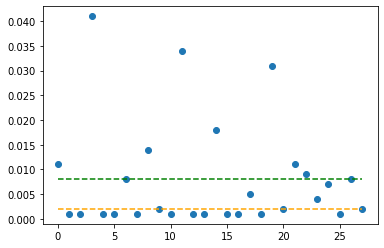

In [ ]:
doc  = doc_top_matrix.loc['Doc0'].values
print
fig,ax = plt.subplots()

vals = np.nonzero(doc)
x = range(0,len(doc[vals]))

mean = doc[-2]
median = doc[-1]
print(mean)
means = [mean]*len(doc[vals])
medians = [median]*len(doc[vals])

ax.scatter(range(0,len(doc[vals])), doc[vals])
ax.plot(x, means, linestyle='--', color="green")
ax.plot(x, medians, linestyle="--", color="orange")

plt.show()

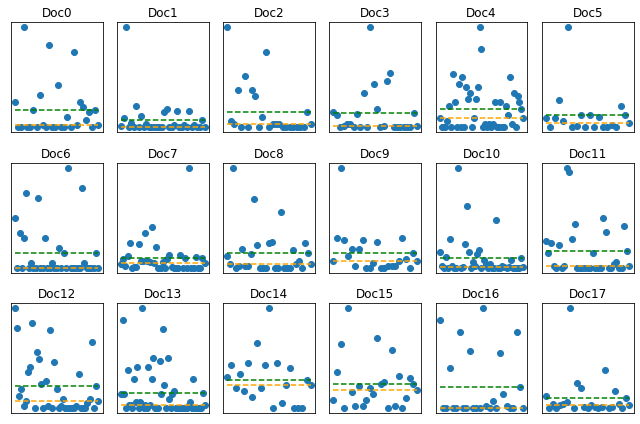

In [ ]:
grid = np.random.rand(4, 4)
docs = [f"Doc{a}" for a in range(18)]

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, docname in zip(axs.flat, docs):
    doc  = doc_top_matrix.loc[docname].values
    vals = np.nonzero(doc)
    x = range(0,len(doc[vals]))

    mean = [doc[-2]]*len(doc[vals])
    median = [doc[-1]]*len(doc[vals])

    ax.scatter(range(0,len(doc[vals])), doc[vals])
    ax.plot(x, mean, linestyle='--', color="green")
    ax.plot(x, median, linestyle="--", color="orange")
    ax.set_title(docname)

plt.tight_layout()
plt.show()

In [ ]:
doc_top_matrix.to_csv("proc/doc_top_matrix.csv")

In [ ]:
def discretize(row):
    if pd.notnull(row['mean']):
        row[row < row['mean']] = 0
        row[row >= row['mean']] = 1
        return row.astype(int)
    else: 
        return row
        

In [ ]:
discrete_dtm = doc_top_matrix.copy().apply(lambda row: discretize(row), axis=1)

In [ ]:
discrete_dtm = discrete_dtm.fillna(0)
discrete_dtm = discrete_dtm.astype(int)

In [ ]:
discrete_dtm

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic492,Topic493,Topic494,Topic495,Topic496,Topic497,Topic498,Topic499,mean,median
Doc0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc51245,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc51246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
Doc51247,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
Doc51248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
discrete_dtm.drop(columns=["mean", "median"], inplace=True)

In [ ]:
sums = discrete_dtm.sum(axis=0)[:-1]
discrete_dtm['source'] = sources.values

In [ ]:
discrete_dtm

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic491,Topic492,Topic493,Topic494,Topic495,Topic496,Topic497,Topic498,Topic499,source
Doc0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,한겨레
Doc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,경항신문
Doc2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,동아일보
Doc3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,중앙일보
Doc4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,중앙일보
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc51245,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,동아일보
Doc51246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,중앙일보
Doc51247,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,중앙일보
Doc51248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,중앙일보


In [ ]:
discrete_dtm.to_csv("proc/discrete_dtm.csv")

In [ ]:
node_list = discrete_dtm.groupby('source').sum().T

In [ ]:
node_list

source,경항신문,동아일보,조선일보,중앙일보,한겨레
Topic0,1,3780,1,0,0
Topic1,0,1846,2,0,0
Topic2,165,59,122,241,101
Topic3,247,87,122,769,62
Topic4,0,531,3,0,1
...,...,...,...,...,...
Topic495,134,75,138,184,99
Topic496,224,204,173,367,134
Topic497,106,39,110,191,75
Topic498,56,11,43,51,58


In [ ]:
node_list.columns

Index(['경항신문', '동아일보', '조선일보', '중앙일보', '한겨레'], dtype='object', name='source')

In [ ]:
node_list["totalcount"] = sums.values
node_list["label"] = topics.values

# Change the order
node_list = node_list[["label", "totalcount", '경항신문', '동아일보', '조선일보', '중앙일보', '한겨레']]

In [ ]:
node_list.label = node_list.label.apply(lambda row: [re.search("\w+", a).group(0) for a in row.split()])

In [ ]:
node_list.sort_values(by="totalcount", ascending=False).head(30)

source,label,totalcount,경항신문,동아일보,조선일보,중앙일보,한겨레
Topic29,"[신종, 코로나바이러스, 코로나바이러스, 사태, 코로나바이러스, 감염, 코로나바이러...",10532,528,2458,487,6523,536
Topic7,"[코로나, 바이러스, 바이러스, 확진자, 바이러스, 인한, 바이러스, 관련, 바이러...",4114,146,135,3041,691,101
Topic22,"[질병, 관리, 관리, 본부, 정은경, 질병, 관리, 본부장, 관리, 부가, 보건,...",3885,744,843,455,1379,464
Topic0,"[탄핵, 추진, 대통령, 추미애, 해임, 탄핵, 주호영, 대통령, 추미애, 해임, ...",3782,1,3780,1,0,0
Topic11,"[자가, 격리, 격리, 기간, 격리, 들어가다, 격리, 위반, 격리, 지침, 격리,...",3405,776,417,513,1148,551
Topic92,"[코로나바이러스, 감염증, 신종, 코로나바이러스, 감염증, 우한, 감염증, 확진, ...",3345,519,428,625,1357,416
Topic51,"[집단, 감염, 감염, 발생, 감염, 사태, 클럽, 집단, 코로나, 집단, 코로나바...",3022,612,600,460,864,486
Topic105,"[확진자, 나오다, 나오다, 않다, 나오다, 이후, 나오다, 않오다, 지난, 확진자...",2753,578,316,433,982,444
Topic62,"[문재인, 대통령, 대통령, 청와대, 청와대, 대변인, 강민석, 청와대, 대통령, ...",2718,497,435,528,852,406
Topic48,"[지역, 사회, 사회, 감염, 사회, 전파, 사회, 확산, 발생, 지역, 감염, 지...",2682,579,519,334,795,455


In [ ]:
node_list.reset_index(inplace=True)
node_list.rename(columns={"index": "topic", "source": "index"}, inplace=True)

node_list.to_csv(f"{PATH}/kor_nodelist.csv")

In [ ]:
node_list

source,topic,label,totalcount,경항신문,동아일보,조선일보,중앙일보,한겨레
0,Topic0,"[탄핵, 추진, 대통령, 추미애, 해임, 탄핵, 주호영, 대통령, 추미애, 해임, ...",3782,1,3780,1,0,0
1,Topic1,"[수사, 심의, 유학, 비용, 자녀, 유학, 욕설, 들다, 보이콧, 막다, 독재, ...",1848,0,1846,2,0,0
2,Topic2,"[판정, 받오다, 확진, 판정, 코로나바이러스, 확진, 받오다, 지난, 지난, 확진...",688,165,59,122,241,101
3,Topic3,"[신종, 코로나, 감염증, 신종, 중국, 신종, 코로나, 대한, 지난, 신종, 따르...",1287,247,87,122,769,62
4,Topic4,"[겨냥, 금융, 비리, 특위, 금융, 비리, 정권, 겨냥, 특위, 만들다, 발언, ...",535,0,531,3,0,1
...,...,...,...,...,...,...,...,...
495,Topic495,"[국난, 극복, 물류, 창고, 정부, 여당, 이낙연, 더불다, 비상, 경제, 대선,...",630,134,75,138,184,99
496,Topic496,"[혈액, 수급, 비상, 걸리다, 행사, 진행, 사회, 공헌, 당국, 비상, 오전, ...",1102,224,204,173,367,134
497,Topic497,"[프란치스코, 교황, 온라인, 생중계, 세계, 최초, 이탈리아, 정부, 메시지, 전...",521,106,39,110,191,75
498,Topic498,"[문화, 회관, 세종, 문화, 이정아, 기자, 서울, 광화문, 잠정, 연기, 온라인...",219,56,11,43,51,58


In [ ]:
# Contact tracing ones! 
node_list.reindex([80, 214, 265, 452])

source,topic,label,totalcount,경항신문,동아일보,조선일보,중앙일보,한겨레
80,Topic80,"[역학, 조사, 조사, 진행, 당국, 역학, 대한, 역학, 조사, 벌이, 조사, 통...",2352,487,344,275,809,437
214,Topic214,"[감염, 경로, 경로, 파악, 경로, 확인, 확진자, 감염, 경로, 없는, 경로, ...",1250,252,206,179,412,201
265,Topic265,"[확진자, 동선, 동선, 공개, 사생활, 침해, 정보, 공개, 공개, 않다, 인권,...",762,184,85,102,273,118
452,Topic452,"[이동, 경로, 확진자, 이동, 줌바, 댄스, 충남, 천안, 경로, 그래픽, 이동,...",111,25,3,11,49,23


# Edge List

In [ ]:
from itertools import combinations
from collections import OrderedDict 

In [ ]:
df = pd.read_pickle("data/korean_proc.pkl")
doc_top_matrix = pd.read_csv("proc/doc_top_matrix.csv")
discrete_dtm = pd.read_csv("proc/discrete_dtm.csv")

In [ ]:
def get_weekday(num):
    # https://docs.python.org/3/library/datetime.html#datetime.date.isocalendar
    if num == 1: return "Monday"
    if num == 2: return "Tuesday"
    if num == 3: return "Wednesday"
    if num == 4: return "Thursday"
    if num == 5: return "Friday"
    if num == 6: return "Saturday"
    if num == 7: return "Sunday"

In [ ]:
def get_political(source):
    """
    Returns true if liberal, false if conservative
    """
    if source in ["한겨레", "경향신문"]:
        return "liberal"
    else: return "conservative"

In [ ]:
def choose(n, k):
    # https://stackoverflow.com/questions/3025162/statistics-combinations-in-python/3025194#3025194
    """
    A fast way to calculate binomial coefficients by Andrew Dalke (contrib).
    """
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

In [ ]:
new_columns = discrete_dtm.columns.values
discrete_dtm.columns = new_columns

In [ ]:
# Number of topics in each document
num_topics_per_document_list = discrete_dtm.sum(axis=1).values

# Figure out combinations space
num_combinations = sum([choose(a, 2) for a in num_topics_per_document_list[:-1]])


In [ ]:
num_combinations

965113

In [ ]:
# Then pre-allocate that much space for the df that will hold the edge list
columns = ["node1", "node2", "documentId", "date", "day_of_week", "week_of_year", "month", "newssource", "political"]
edgelist = pd.DataFrame(columns=columns, index=range(num_combinations))


In [ ]:
discrete_dtm['num_topics_in_document'] = num_topics_per_document_list

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
i = 0
for index, row in discrete_dtm.iterrows():
    print(index)
    if row.num_topics_in_document > 1:
#         print(row.num_topics_in_document)
        
        documentId = index#int(re.search('\d+', index).group())
        document = df.loc[documentId] # fetch document
        newssource = document.source
        political = get_political(newssource)
        
        date = parse(document.date)
#         print(document.source)
        _, week_of_year, day_of_week = date.isocalendar()
        month = date.month
        day_of_week = get_weekday(day_of_week)
        
        topic_combinations = combinations(row.index[row == 1], 2)
        
        for node1, node2 in topic_combinations:
#             print(node1, node2)
            
            onerow = pd.Series({"node1": node1, "node2": node2, "documentId": documentId, 
                                "date": date, "day_of_week": day_of_week, "week_of_year": week_of_year,
                                "month": month, "newssource": newssource, "political": political})
            
            edgelist.iloc[i] = onerow
            i += 1


In [ ]:
edgelist[10000:20000]

,node1,node2,documentId,date,day_of_week,week_of_year,month,newssource,political
10000,Topic22,Topic213,289,2020-02-03 00:00:00,Monday,6,2,중앙일보,conservative
10001,Topic22,Topic239,289,2020-02-03 00:00:00,Monday,6,2,중앙일보,conservative
10002,Topic22,Topic265,289,2020-02-03 00:00:00,Monday,6,2,중앙일보,conservative
10003,Topic22,Topic282,289,2020-02-03 00:00:00,Monday,6,2,중앙일보,conservative
10004,Topic22,Topic383,289,2020-02-03 00:00:00,Monday,6,2,중앙일보,conservative
...,...,...,...,...,...,...,...,...,...
19995,Topic218,Topic376,626,2020-02-03 00:00:00,Monday,6,2,조선일보,conservative
19996,Topic294,Topic296,626,2020-02-03 00:00:00,Monday,6,2,조선일보,conservative
19997,Topic294,Topic376,626,2020-02-03 00:00:00,Monday,6,2,조선일보,conservative
19998,Topic296,Topic376,626,2020-02-03 00:00:00,Monday,6,2,조선일보,conservative


In [ ]:
edgelist.to_csv("proc/kor_edgelist.csv")
edgelist.to_pickle("proc/kor_edgelist.pkl")

In [ ]:
# WEIGHTED EDGE LIST

df_weight = edgelist[["node1", "node2"]]
df_weight = df_weight.groupby(df_weight.columns.tolist(),as_index=False).size().reset_index().rename(columns={0:'weight'})


In [ ]:
df_weight[df_weight['weight'] > 1]

,node1,node2,weight
0,Topic0,Topic10,29
1,Topic0,Topic100,69
2,Topic0,Topic101,14
3,Topic0,Topic103,63
4,Topic0,Topic104,25
...,...,...,...
68541,Topic99,Topic495,9
68542,Topic99,Topic496,99
68543,Topic99,Topic497,8
68544,Topic99,Topic498,4


In [ ]:
df_weight.sort_values("weight", ascending=False, inplace=True)
weights = df_weight.sort_values("weight", ascending=False).weight.values


(array([16., 17., 16.,  9.,  7.,  3., 12.,  5.,  1.,  3.,  1.,  2.,  1.,
         0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.]),
 array([ 366. ,  402.5,  439. ,  475.5,  512. ,  548.5,  585. ,  621.5,
         658. ,  694.5,  731. ,  767.5,  804. ,  840.5,  877. ,  913.5,
         950. ,  986.5, 1023. , 1059.5, 1096. , 1132.5, 1169. , 1205.5,
        1242. , 1278.5, 1315. , 1351.5, 1388. , 1424.5, 1461. ]),
 <a list of 30 Patch objects>)

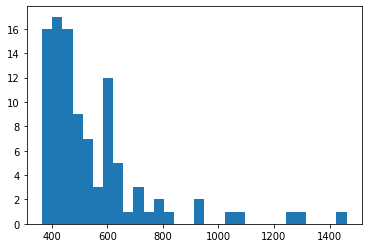

In [ ]:
plt.hist(weights[:100], bins = 30)

In [ ]:
df_weight

,node1,node2,weight
40815,Topic29,Topic92,1461
193,Topic0,Topic29,1309
161,Topic0,Topic26,1244
59927,Topic7,Topic294,1073
403,Topic0,Topic9,1030
...,...,...,...
35434,Topic256,Topic424,1
35433,Topic256,Topic419,1
35432,Topic256,Topic411,1
56455,Topic58,Topic292,1


In [ ]:
df_weight.to_csv("proc/kor_edgelist_weight.csv")

# Filtering, finding articles to analyze

In [ ]:
import pandas as pd
import pickle
import networkx as nx
from collections import Counter
import re
import plotly.graph_objects as go
import math
import ast

In [ ]:
len(df)

51250

In [ ]:
len(df.drop_duplicates("text"))

50937

In [ ]:
edgelist = pd.read_csv("proc/kor_edgelist_weight.csv")
edgelist.drop(columns="Unnamed: 0", inplace=True)

nodelist = pd.read_csv("proc/kor_nodelist.csv")
nodelist.drop(columns="Unnamed: 0", inplace=True)

In [ ]:
topics = pd.read_csv('models/nmf_topics.txt', header=None)

In [ ]:
topics

,0
0,탄핵 추진 대통령 추미애 해임 탄핵 주호영 대통령 추미애 해임 위원장 쓸이에 쓸이에...
1,수사 심의 유학 비용 자녀 유학 욕설 들다 보이콧 막다 독재 보이콧 대상 수사 심의...
2,판정 받오다 확진 판정 코로나바이러스 확진 받오다 지난 지난 확진 남성 확진 받오다...
3,신종 코로나 감염증 신종 중국 신종 코로나 대한 지난 신종 따르다 신종 정부 신종 ...
4,겨냥 금융 비리 특위 금융 비리 정권 겨냥 특위 만들다 발언 누군지 추미애 울다 누...
...,...
495,국난 극복 물류 창고 정부 여당 이낙연 더불다 비상 경제 대선 주자 경제 대책 국회...
496,혈액 수급 비상 걸리다 행사 진행 사회 공헌 당국 비상 오전 오후 관리 본부 사회 ...
497,프란치스코 교황 온라인 생중계 세계 최초 이탈리아 정부 메시지 전달 보도 나오다 우...
498,문화 회관 세종 문화 이정아 기자 서울 광화문 잠정 연기 온라인 생중계 방역 작업 ...


In [ ]:
topics.reindex([80,214,265,452])

,0
80,역학 조사 조사 진행 당국 역학 대한 역학 조사 벌이 조사 통해 조사 과정 심층 역...
214,감염 경로 경로 파악 경로 확인 확진자 감염 경로 없는 경로 조사 경로 아직 확인 ...
265,확진자 동선 동선 공개 사생활 침해 정보 공개 공개 않다 인권 침해 확진자 다녀가다...
452,이동 경로 확진자 이동 줌바 댄스 충남 천안 경로 그래픽 이동 동선 경로 조사 확진...


In [ ]:
nodelist

,topic,label,totalcount,경항신문,동아일보,조선일보,중앙일보,한겨레
0,Topic0,"['탄핵', '추진', '대통령', '추미애', '해임', '탄핵', '주호영', ...",3782,1,3780,1,0,0
1,Topic1,"['수사', '심의', '유학', '비용', '자녀', '유학', '욕설', '들다...",1848,0,1846,2,0,0
2,Topic2,"['판정', '받오다', '확진', '판정', '코로나바이러스', '확진', '받오...",688,165,59,122,241,101
3,Topic3,"['신종', '코로나', '감염증', '신종', '중국', '신종', '코로나', ...",1287,247,87,122,769,62
4,Topic4,"['겨냥', '금융', '비리', '특위', '금융', '비리', '정권', '겨냥...",535,0,531,3,0,1
...,...,...,...,...,...,...,...,...
495,Topic495,"['국난', '극복', '물류', '창고', '정부', '여당', '이낙연', '더...",630,134,75,138,184,99
496,Topic496,"['혈액', '수급', '비상', '걸리다', '행사', '진행', '사회', '공...",1102,224,204,173,367,134
497,Topic497,"['프란치스코', '교황', '온라인', '생중계', '세계', '최초', '이탈리...",521,106,39,110,191,75
498,Topic498,"['문화', '회관', '세종', '문화', '이정아', '기자', '서울', '광...",219,56,11,43,51,58


In [ ]:
# Contact tracing indexes
ct_idxs = ["Topic80", "Topic214", "Topic265", "Topic452"]
ct_idxs = ["Topic214"]

In [ ]:
ct_topics = edgelist[edgelist['node1'].isin(ct_idxs)]
ct_topics = ct_topics.append(edgelist[edgelist['node2'].isin(ct_idxs)])
ct_topics = ct_topics.sort_values(by="weight", ascending=False)

In [ ]:
ct_topics

,node1,node2,weight
98,Topic80,Topic214,367
137,Topic51,Topic214,319
150,Topic29,Topic214,301
179,Topic66,Topic214,275
180,Topic105,Topic214,275
...,...,...,...
65574,Topic214,Topic292,1
65591,Topic214,Topic275,1
65609,Topic214,Topic271,1
65610,Topic214,Topic266,1


In [ ]:
edges = ct_topics[:15]

In [ ]:
topics = list(set(list_flatten(edges[['node1', 'node2']].values.tolist())))

# dictionary mapping topic to name
topic_name_dict = nodelist[nodelist.topic.isin(topics)]
topic_name_dict["label"] = topic_name_dict.label.apply(lambda a: ast.literal_eval(a))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
nodelist_weighted = nodelist.sort_values(by="totalcount", ascending=False)
nodelist_weighted.reset_index(drop=False, inplace=True)
nodelist_weighted[nodelist_weighted.topic.isin(ct_idxs)]

,index,topic,label,totalcount,경항신문,동아일보,조선일보,중앙일보,한겨레
49,214,Topic214,"['감염', '경로', '경로', '파악', '경로', '확인', '확진자', '감...",1250,252,206,179,412,201


In [ ]:
weights = nodelist_weighted[nodelist_weighted.totalcount != 0]
weights = weights[weights.totalcount < 3000].totalcount.values

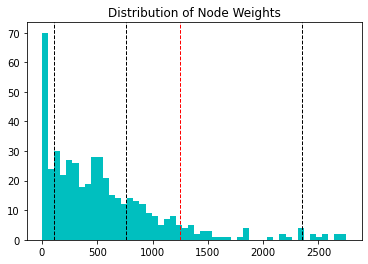

In [ ]:
result = plt.hist(weights, 50, color='c')
result = plt.axvline(2352, color='k', linestyle='dashed', linewidth=1) # 80 - 역학-조사
result = plt.axvline(1250, color='r', linestyle='dashed', linewidth=1) # 214- 감염-경로
result = plt.axvline(762, color='k', linestyle='dashed', linewidth=1)  # 265 확진자-동선
result = plt.axvline(111, color='k', linestyle='dashed', linewidth=1)  # 452 이동-경로

result = plt.title("Distribution of Node Weights")

In [ ]:
e_weights = edgelist[edgelist.weight > 200]
e_weights = e_weights.weight.values

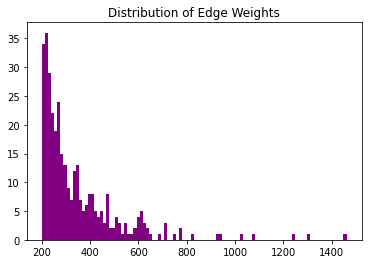

In [ ]:
result = plt.hist(e_weights, 100, color = 'purple')
result = plt.title("Distribution of Edge Weights")


In [ ]:
ct_topics

,node1,node2,weight
98,Topic80,Topic214,367
137,Topic51,Topic214,319
150,Topic29,Topic214,301
179,Topic66,Topic214,275
180,Topic105,Topic214,275
...,...,...,...
65574,Topic214,Topic292,1
65591,Topic214,Topic275,1
65609,Topic214,Topic271,1
65610,Topic214,Topic266,1


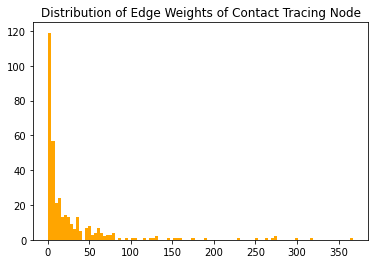

In [ ]:
result = plt.hist(ct_topics.weight.values, 100, color = 'orange')
# result = plt.axvline(1338, color='k', linestyle='dashed', linewidth=1)
result = plt.title("Distribution of Edge Weights of Contact Tracing Node")


In [ ]:
len(ct_topics)

363

In [ ]:
len(ct_topics[ct_topics.weight > 60]) 

43

In [ ]:
len(ct_topics[ct_topics.weight > 30]) 

93

In [ ]:
len(ct_topics[ct_topics.weight > 20]) 

124

In [ ]:
ct_topics

,node1,node2,weight
98,Topic80,Topic214,367
137,Topic51,Topic214,319
150,Topic29,Topic214,301
179,Topic66,Topic214,275
180,Topic105,Topic214,275
...,...,...,...
65574,Topic214,Topic292,1
65591,Topic214,Topic275,1
65609,Topic214,Topic271,1
65610,Topic214,Topic266,1


In [ ]:
nodelist_weighted[nodelist_weighted.topic.isin(top_edges.node1.values)]

,index,topic,label,totalcount,경항신문,동아일보,조선일보,중앙일보,한겨레
0,29,Topic29,"['신종', '코로나바이러스', '코로나바이러스', '사태', '코로나바이러스', ...",10532,528,2458,487,6523,536
1,7,Topic7,"['코로나', '바이러스', '바이러스', '확진자', '바이러스', '인한', '...",4114,146,135,3041,691,101
2,22,Topic22,"['질병', '관리', '관리', '본부', '정은경', '질병', '관리', '본...",3885,744,843,455,1379,464
3,0,Topic0,"['탄핵', '추진', '대통령', '추미애', '해임', '탄핵', '주호영', ...",3782,1,3780,1,0,0
4,11,Topic11,"['자가', '격리', '격리', '기간', '격리', '들어가다', '격리', '...",3405,776,417,513,1148,551
6,51,Topic51,"['집단', '감염', '감염', '발생', '감염', '사태', '클럽', '집단...",3022,612,600,460,864,486
7,105,Topic105,"['확진자', '나오다', '나오다', '않다', '나오다', '이후', '나오다'...",2753,578,316,433,982,444
9,48,Topic48,"['지역', '사회', '사회', '감염', '사회', '전파', '사회', '확산...",2682,579,519,334,795,455
10,99,Topic99,"['검사', '받다', '받다', '확진', '진료', '검사', '받다', '음성...",2644,492,334,359,967,492
12,33,Topic33,"['음성', '판정', '검사', '음성', '판정', '받다', '판정', '나오...",2579,482,455,339,922,381


In [ ]:
df = pd.read_pickle("data/korean_proc.pkl")
edgelist_full = pd.read_csv("proc/kor_edgelist.csv")

In [ ]:
threshold = 60
threshold = 30
threshold = 20

top_edges = ct_topics[ct_topics.weight > threshold]

# top_edges

In [ ]:
for index, row in top_edges.iterrows():
    # Find all the edges that include this specific edge
    edges = edgelist_full[(edgelist_full.node1 == row.node1) & (edgelist_full.node2 == row.node2)]
    
    # Get the document ids
    docIds = edges.documentId.values
    
    # Get the documents corresponding to these edges
    documents = df[df.index.isin(docIds)][["title", "date", "url", "keyword", "text", "source"]]
    documents.reset_index(inplace=True)
    
    textfile = f"[{len(edges)}]{row.node1}-{row.node2}.csv"
    print(textfile)
    
    documents.to_csv(f"texts_to_analyze_{threshold}/{textfile}")

[367]Topic80-Topic214.csv
[319]Topic51-Topic214.csv
[301]Topic29-Topic214.csv
[275]Topic66-Topic214.csv
[275]Topic105-Topic214.csv
[270]Topic141-Topic214.csv
[262]Topic48-Topic214.csv
[253]Topic22-Topic214.csv
[229]Topic99-Topic214.csv
[191]Topic21-Topic214.csv
[174]Topic33-Topic214.csv
[161]Topic11-Topic214.csv
[156]Topic214-Topic239.csv
[152]Topic197-Topic214.csv
[145]Topic195-Topic214.csv
[132]Topic214-Topic320.csv
[130]Topic122-Topic214.csv
[128]Topic214-Topic481.csv
[123]Topic55-Topic214.csv
[115]Topic86-Topic214.csv
[106]Topic24-Topic214.csv
[100]Topic131-Topic214.csv
[93]Topic214-Topic383.csv
[87]Topic214-Topic231.csv
[81]Topic214-Topic298.csv
[80]Topic2-Topic214.csv
[80]Topic117-Topic214.csv
[80]Topic20-Topic214.csv
[77]Topic1-Topic214.csv
[76]Topic119-Topic214.csv
[75]Topic147-Topic214.csv
[73]Topic214-Topic243.csv
[72]Topic196-Topic214.csv
[72]Topic208-Topic214.csv
[69]Topic183-Topic214.csv
[67]Topic198-Topic214.csv
[66]Topic0-Topic214.csv
[65]Topic214-Topic247.csv
[64]Topic6

Make a table

In [ ]:
# get the list of nodes/topics
topics = list(set(list_flatten(top_edges[['node1', 'node2']].values.tolist())))

# dictionary mapping topic to name
topic_name_dict = nodelist[nodelist.topic.isin(topics)]
topic_name_dict["label"] = topic_name_dict.label.apply(lambda a: ast.literal_eval(a))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
node1_bow = []
node2_bow = []

for index, row in top_edges.iterrows():
    bow = topic_name_dict[topic_name_dict.topic == row.node1].label.values[0]
    node1_bow.append(' '.join(["-".join(bow[i:i+2]) for i in range(0, len(bow), 2)]))
    
    bow = topic_name_dict[topic_name_dict.topic == row.node2].label.values[0]
    node2_bow.append(' '.join(["-".join(bow[i:i+2]) for i in range(0, len(bow), 2)]))
    
    


In [ ]:
top_edges["node1_bow"] = node1_bow
top_edges["node2_bow"] = node2_bow

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
top_edges.to_csv(f"texts_to_analyze_{threshold}/top_edges_table.csv")